In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import math
import json
import os
import wandb
from datasets import get_real_dataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

color_pallete = "colorblind"
cb = list(sns.color_palette(color_pallete))
color_pallete = "rocket"
rocket = list(sns.color_palette(color_pallete))

sns.set_palette([cb[4] ,cb[-2], cb[3], cb[0], cb[-4], rocket[0]])

In [61]:
project_path = "whfourier/EntacmaeaEarly"
dataset_name = "Entacmaea"

dataset = get_real_dataset(dataset_name)
n = dataset.X.shape[1]

# dataset_name = f"{dataset_name}_reduced"
file = f"files/{dataset_name}.json"

criteria = {
    "fix_seed": [1, 2, 3, 4, 5],
    "random_seed": [11, 22, 33, 44, 55],
    "train_size": [40, 60, 80, 100, 120, 140, 160, 180, 200],
    # "train_size": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    # "training_method": [ "Lasso", "Random Forest", "XGBoost", "normal", "EN-S", "hashing", "alternate (SPRIGHT)", "alternate (swht)"]
    "training_method": [ "Lasso", "Random Forest", "XGBoost", "normal", "EN-S", "hashing"]
}

random_forest_max_depths = None
# random_forest_max_depths = [10, 20, 30]

Loaded dataset from cache.


## Size-R2 plot

In [14]:
api = wandb.Api(timeout=120)
early_stop = 10
ml = [ "Lasso", "Random Forest", "XGBoost"]

best_results = {} # train_size.training_method
runtimes = {} # train_size.training_method
for train_size in criteria["train_size"]:
    best_results_train_size = {}
    runtimes_train_size = {}
    for training_method in criteria["training_method"]:
        filters = {f'config.{k}': v for k, v in criteria.items()}
        filters["config.training_method"] = training_method
        filters["config.train_size"] = train_size
        filters.pop("config.fix_seed", None)
        filters.pop("config.random_seed", None)

        if random_forest_max_depths is not None and (training_method == "Random Forest" or training_method == "XGBoost"):
            filters["config.rf_max_depth"] = {"$in":random_forest_max_depths}
        
        if training_method == "alternate (SPRIGHT)":
            filters["config.training_method"] = "alternate"
            filters["config.fourier_method"] = {"$ne": "swht"}
        elif training_method == "alternate (swht)":
            filters["config.training_method"] = "alternate"
            filters["config.fourier_method"] = "swht"
        elif training_method == "EN-S":
            filters["config.b"] = 7
        # elif training_method == "hashing":
        #     filters["config.b"] = {"$ne": 16}
        
        runs = api.runs(project_path, filters=filters)
        print(train_size, training_method, len(runs))

        best_results_training_method = []
        runtimes_training_method = []
        for fix_seed in criteria["fix_seed"]:
            for random_seed in criteria["random_seed"]:
                best_model_idx = np.argmax([run.summary.get("max_val_r2", -math.inf) if run.config["fix_seed"]==fix_seed and run.config["random_seed"]==random_seed else -math.inf 
                                            for run in runs])
                best_results_training_method.append(runs[best_model_idx].summary.get("best_test_r2", -math.inf))
                if "train_time" in runs[best_model_idx].summary:
                    if not training_method in ml:
                        runtimes_training_method.append(np.sum(runs[best_model_idx].history()["train_time"][:-early_stop]))
                    else:
                        runtimes_training_method.append(runs[best_model_idx].summary["train_time"])
                else:
                    runtimes_training_method.append(runs[best_model_idx].summary.get("_runtime", -math.inf))
            
        best_results_train_size[training_method] = best_results_training_method
        runtimes_train_size[training_method] = runtimes_training_method
    best_results[train_size] = best_results_train_size
    runtimes[train_size] = runtimes_train_size

# Save
data_to_dump = {
    "best_results": best_results,
    "runtimes": runtimes,
}
with open(file, "w") as outfile:
    json.dump(data_to_dump, outfile)



200 Lasso 150
200 Random Forest 500
200 XGBoost 500
200 normal 25
200 EN-S 25
200 hashing 225
400 Lasso 150
400 Random Forest 500
400 XGBoost 500
400 normal 25
400 EN-S 25
400 hashing 225
600 Lasso 150
600 Random Forest 500
600 XGBoost 500
600 normal 25
600 EN-S 25
600 hashing 225
800 Lasso 150
800 Random Forest 500
800 XGBoost 500
800 normal 25
800 EN-S 25
800 hashing 225
1000 Lasso 150
1000 Random Forest 500
1000 XGBoost 500
1000 normal 25
1000 EN-S 25
1000 hashing 225
1200 Lasso 150
1200 Random Forest 500
1200 XGBoost 500
1200 normal 25
1200 EN-S 25
1200 hashing 225
1400 Lasso 150
1400 Random Forest 502
1400 XGBoost 501
1400 normal 25
1400 EN-S 25
1400 hashing 225
1600 Lasso 150
1600 Random Forest 500
1600 XGBoost 501
1600 normal 25
1600 EN-S 25
1600 hashing 225
1800 Lasso 150
1800 Random Forest 500
1800 XGBoost 500
1800 normal 25
1800 EN-S 25
1800 hashing 225
2000 Lasso 150
2000 Random Forest 500
2000 XGBoost 500
2000 normal 25
2000 EN-S 25
2000 hashing 225


In [62]:
# Load
with open(file) as f:
    dumped_data = json.load(f)
    best_results = dumped_data["best_results"]
    runtimes = dumped_data["runtimes"]

for train_size in criteria["train_size"]:
    best_results[train_size] = best_results.pop(str(train_size))
    runtimes[train_size] = runtimes.pop(str(train_size))

# Rename methods for plotting
renames ={
    "normal": "standard",
    "hashing": "HashWH (Ours)",
}

training_methods = criteria["training_method"]
new_methods = {k:k for k in training_methods}
for name, replacement in renames.items():
    for method in new_methods.keys():
        new_methods[method] = new_methods[method].replace(name, replacement)

for train_size in criteria["train_size"]:
    for method, new_name in new_methods.items():
        best_results[train_size][new_name] = best_results[train_size].pop(method)
        runtimes[train_size][new_name] = runtimes[train_size].pop(method)

/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8, 0.47058823529411764, 0.7372549019607844)) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.9254901960784314, 0.8823529411764706, 0.2)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker

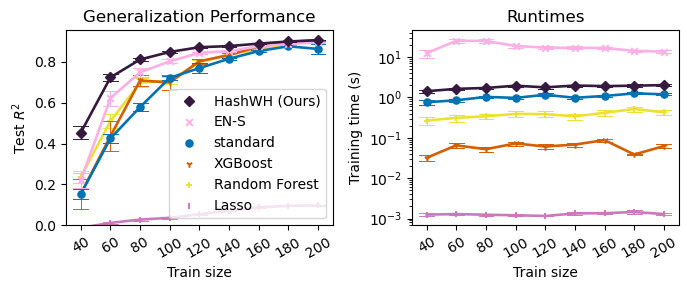

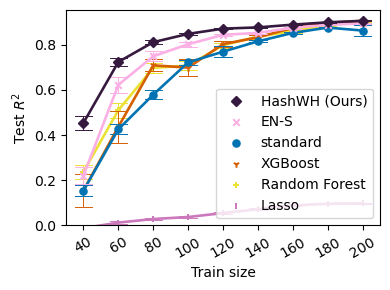

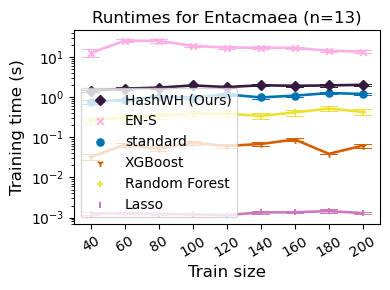

In [63]:
markers = ['|', '+', '1', 'o', 'x', 'D', 'p', '8', 's', 'p', 'D', 'V']
results = {"Training method":[], "Train size": [], "Validation R2": [], "Runtime": []}
for train_size in criteria["train_size"]:
    for training_method in new_methods.values():
        results["Training method"].extend([training_method] * len(best_results[train_size][training_method]))
        results["Train size"].extend([train_size] * len(best_results[train_size][training_method]))
        results["Validation R2"].extend(best_results[train_size][training_method])
        results["Runtime"].extend(runtimes[train_size][training_method])

scale = 0.7
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True)
# R2
g = sns.pointplot(x="Train size", y="Validation R2", hue="Training method",errorbar='se', scale=scale,
            capsize=.5, data=pd.DataFrame.from_dict(results), errwidth=0.7, ax=axes[0], markers=markers)
axes[0].set_ylabel("Test $R^2$")
axes[0].set_title("Generalization Performance")
axes[0].tick_params(axis='x', labelrotation=30)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], loc='lower right').set_zorder(102)
g.set(ylim=(0, None))


# Time
g = sns.pointplot(x="Train size", y="Runtime", hue="Training method", errorbar='se', scale=scale,
            capsize=.5, data=pd.DataFrame.from_dict(results), errwidth=0.7, ax=axes[1], markers=markers)
axes[1].set_ylabel("Training time (s)")
axes[1].set_title("Runtimes")
g.set(yscale="log")
axes[1].get_legend().remove()
# fig.suptitle(f"Performance on {dataset_name} dataset", fontsize=14)
axes[1].tick_params(axis='x', labelrotation=30)
fig.tight_layout()
plt.savefig(f'files/{dataset_name}_performance.pdf')

### SPLIT
# R2
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
g = sns.pointplot(x="Train size", y="Validation R2", hue="Training method",errorbar='se', scale=scale,
            capsize=.5, data=pd.DataFrame.from_dict(results), errwidth=0.7, ax=ax, markers=markers)
ax.set_ylabel("Test $R^2$")
g.set(ylim=(0, None))
plt.xticks(rotation=30)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower right').set_zorder(102)
fig.tight_layout()
plt.savefig(f'files/{dataset_name}_score.pdf')

# Time
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
g = sns.pointplot(x="Train size", y="Runtime", hue="Training method", errorbar='se', scale=scale,
            capsize=0.5, data=pd.DataFrame.from_dict(results), errwidth=0.7, ax=ax, markers=markers)
ax.set_ylabel("Training time (s)", size="large")
ax.set_xlabel("Train size", size="large")
ax.set_title(f"Runtimes for {dataset_name.split('_')[0]} (n={n})")
g.set(yscale="log")
plt.xticks(rotation=30)
fig.tight_layout()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left').set_zorder(102)
plt.savefig(f'files/{dataset_name}_runtime.pdf')

## Time-R2 plot

1000 normal {-1} {-1} 15
1000 EN-S {5, 7} {-1} 30
1000 hashing {16, 10, 13, 7} {-1} 180


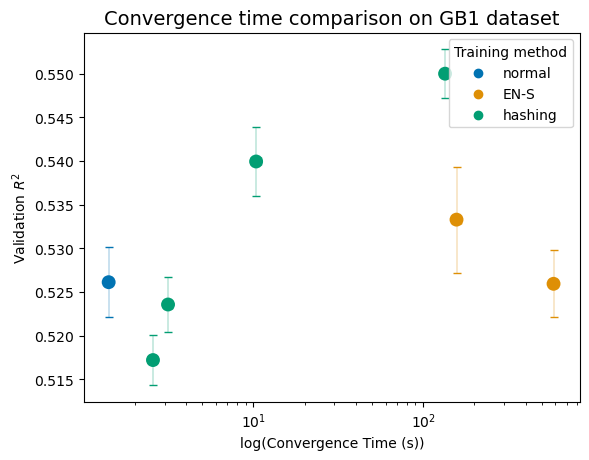

In [33]:
api = wandb.Api(timeout=60)
train_size = 1000
skip_list = ["Lasso", "Random Forest", "XGBoost"]

results = {"Training method":[], "Time": [], "Validation R2": []}
agg_results = {"Training method":[], "Time": [], "Time Error": [], "Validation R2": [], "Validation R2 Error": []}
best_results_train_size = {}
for training_method in criteria["training_method"]:
    if training_method in skip_list:
        continue
    filters = {f'config.{k}': v for k, v in criteria.items()}
    filters["config.training_method"] = training_method
    filters["config.train_size"] = train_size
    filters.pop("config.fix_seed", None)
    filters.pop("config.random_seed", None)

    if training_method == "alternate (SPRIGHT)":
        filters["config.training_method"] = "alternate"
        filters["config.fourier_method"] = {"$ne": "swht"}
    elif training_method == "alternate (swht)":
        filters["config.training_method"] = "alternate"
        filters["config.fourier_method"] = "swht"
    # elif training_method == "hashing":
    #     filters["config.b"] = {"$ne": 16}

    runs = api.runs(project_path, filters=filters)
    
    bs = set([run.config.get("b", -1) for run in runs])
    fourier_ds = set([run.config.get("fourier_d", -1) for run in runs])
    print(train_size, training_method, bs, fourier_ds, len(runs))

    for b in bs:
        for fourier_d in fourier_ds:
            filtered_runs = [run for run in runs if (run.config.get("b", -1)==b) and (run.config.get("fourier_d", -1)==fourier_d)]
            best_models = []
            for fix_seed in criteria["fix_seed"]:
                for random_seed in criteria["random_seed"]:
                    best_model_idx = np.argmax([run.summary.get("max_val_r2", -math.inf) if run.config["fix_seed"]==fix_seed and run.config["random_seed"]==random_seed else -math.inf 
                                                for run in filtered_runs])
                    best_models.append(filtered_runs[best_model_idx])
                    # Add to results
                    results["Training method"].append(training_method)
                    results["Time"].append(filtered_runs[best_model_idx].summary["_runtime"])
                    results["Validation R2"].append(filtered_runs[best_model_idx].summary["best_test_r2"])
            
            times = [np.sum(run.history()["train_time"]) for run in best_models]
            r2s = [run.summary["best_test_r2"] for run in best_models]
            # Add to aggregated results
            agg_results["Training method"].append(training_method)
            agg_results["Time"].append(np.mean(times))
            agg_results["Time Error"].append(np.std(times)/np.sqrt(len(times)))
            agg_results["Validation R2"].append(np.mean(r2s))
            agg_results["Validation R2 Error"].append(np.std(r2s)/np.sqrt(len(r2s)))
            

g = sns.scatterplot(x="Time", y="Validation R2", hue="Training method", data=pd.DataFrame.from_dict(agg_results),
                 linewidth=0, s=100)
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
color_list = sns.color_palette(color_pallete, as_cmap=True)
color_inds = [[tm for tm in criteria["training_method"] if tm not in skip_list].index(x) for x in agg_results["Training method"]]
for i in range(len(agg_results["Time"])):
    g.errorbar(agg_results["Time"][i], agg_results["Validation R2"][i], xerr=agg_results["Time Error"][i], yerr=agg_results["Validation R2 Error"][i],
        markersize=0, capsize=3, elinewidth=0.3, ecolor=color_list[color_inds[i]], zorder=0)
# for cap in caps:
#     cap.set_markeredgewidth(0.5)

g.set_xlabel("log(Convergence Time (s))")
g.set_ylabel("Validation $R^2$")
g.set_title(f"Convergence time comparison on {dataset_name} dataset", fontsize=14)
plt.xscale('log')
plt.savefig('files/avGFP_time.pdf')


<Figure size 640x480 with 0 Axes>